In [6]:
import cv2
import math
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import os
import time


def nearest_neighbor(img, scale_factor):
    old_h, old_w = img.shape[:2]
    new_h, new_w = int(old_h * scale_factor), int(old_w * scale_factor)
    resized = np.zeros((new_h, new_w), dtype=np.uint8)

    h_scale = old_h / new_h
    w_scale = old_w / new_w

    for i in range(new_h):
        for j in range(new_w):
            x = int(i * h_scale)
            y = int(j * w_scale)
            resized[i, j] = img[x, y]

    return resized


def bilinear(original_img, scale_factor):
    old_h, old_w = original_img.shape
    new_h, new_w = int(old_h * scale_factor), int(old_w * scale_factor)
    resized = np.zeros((new_h, new_w), dtype=np.uint32)

    w_scale_factor = (old_w - 1) / (new_w - 1) if new_w != 1 else 0
    h_scale_factor = (old_h - 1) / (new_h - 1) if new_h != 1 else 0

    for i in range(new_h):
        for j in range(new_w):
            x = i * h_scale_factor
            y = j * w_scale_factor
            x_floor = math.floor(x)
            x_ceil = min(old_h - 1, math.ceil(x))
            y_floor = math.floor(y)
            y_ceil = min(old_w - 1, math.ceil(y))

            if (x_ceil == x_floor) and (y_ceil == y_floor):
                q = original_img[int(x), int(y)]
            elif (x_ceil == x_floor):
                q1 = original_img[int(x_floor), int(y)]
                q2 = original_img[int(x_ceil), int(y)]
                q = (q1 * (x_ceil - x)) + (q2 * (x - x_floor))
            elif (y_ceil == y_floor):
                q1 = original_img[int(x), int(y_floor)]
                q2 = original_img[int(x), int(y_ceil)]
                q = (q1 * (y_ceil - y)) + (q2 * (y - y_floor))
            else:
                v1 = original_img[x_floor, y_floor]
                v2 = original_img[x_ceil, y_floor]
                v3 = original_img[x_floor, y_ceil]
                v4 = original_img[x_ceil, y_ceil]

                q1 = (v1 * (x_ceil - x)) + (v2 * (x - x_floor))
                q2 = (v3 * (x_ceil - x)) + (v4 * (x - x_floor))
                q = (q1 * (y_ceil - y)) + (q2 * (y - y_floor))

            resized[i, j] = q

    return resized.astype(np.uint8)


def cubic(v, l):

    n = len(v)
    step = n / l
    result = []
    u = [v[0], v[0]] + list(v) + [v[-1], v[-1]]
    u = np.asarray(u, dtype=np.float16)

    for k in range(l):
        x = (k + 0.5)*step + 1.5
        i = int(x)
        j = i + 1
        t = 1 - (j - x)
        y0 = u[i]
        y1 = u[j]
        m0 = (u[j] - u[i-1]) / 2
        m1 = (u[j+1] - u[i]) / 2
        a = 2*y0 - 2*y1 + m0 + m1
        b = -3*y0 + 3*y1 - 2*m0 - m1
        c = m0
        d = y0
        result.append(a*t**3 + b*t**2 + c*t + d)

    return result


def bicubic(m, scale):
    nh = int(m.shape[0]*scale)
    nw = int(m.shape[1]*scale)
    h = len(m)
    result = np.zeros([nh, nw], m.dtype)
    rows = []

    for k in range(h):
        rows.append(cubic(m[k], nw))

    for k in range(nw):
        col = [rows[j][k] for j in range(h)]
        new_col = cubic(col, nh)

        for j in range(nh):
            result[j][k] = new_col[j]

    return result


def lanczos_kernel(x, a):
    if x == 0:
        return 1
    elif x >= -a and x < a:
        return (a*np.sin(np.pi*x)*np.sin(np.pi*x/a)) / (np.power(np.pi, 2)*np.power(x, 2))
    else:
        return 0


def lanczos(v, l, a=4):
    n = len(v)
    step = n / l
    result = []

    for dx in range(l):
        x = (dx + 0.5)*step - 0.5
        xf = int(x)

        y = 0

        for i in range(xf-a+1, xf+a+1):
            j = i

            if i < 0:
                j = 0
            elif i > n-1:
                j = n-1

            y += v[j] * lanczos_kernel(x - i, a)

        result.append(y)

    return result


def bilanczos(m, scale, a=2):
    nh = int(m.shape[0]*scale)
    nw = int(m.shape[1]*scale)
    h = len(m)
    result = np.zeros([nh, nw], m.dtype)
    rows = []

    for k in range(h):
        rows.append(lanczos(m[k], nw, a))

    for k in range(nw):
        col = []

        for j in range(h):
            col.append(rows[j][k])

        new_col = lanczos(col, nh, a)

        for j in range(nh):
            result[j][k] = new_col[j]

    return result


def interpolation(img_name, scale=2):

    filename = f'{img_name[:-4]}_{scale}x.jpg'

    original_img = cv2.imread(img_name, 0)

    resized_img = cv2.imread(filename, 0)

    output_dir = 'pics'

    start_time = time.time()
    resized_nn = nearest_neighbor(original_img, scale)
    end_time = time.time()
    print("Time taken for nearest neighbor:", end_time - start_time, "seconds")


    start_time = time.time()
    resized_bl = bilinear(original_img, scale)
    end_time = time.time()
    print("Time taken for bilinear:", end_time - start_time, "seconds")


    start_time = time.time()
    resized_bc = bicubic(original_img, scale)
    end_time = time.time()
    print("Time taken for bicubic:", end_time - start_time, "seconds")

    start_time = time.time()
    resized_lc = bilanczos(original_img, scale, 2)
    end_time = time.time()
    print("Time taken for bilanczos:", end_time - start_time, "seconds")

    fig, ax = plt.subplots(2, 3, figsize=(12, 20))

    ax[0][0].imshow(original_img, cmap='gray')
    ax[0][0].set_title('Original Image')
    ax[0][0].axis('off')

    psnr_score = peak_signal_noise_ratio(resized_img, resized_img)
    ssim_score = structural_similarity(resized_img, resized_img)

    ax[0][1].imshow(resized_img, cmap='gray')
    ax[0][1].set_title(
        f'Resized Image\n PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.2f}', fontsize=10)
    ax[0][1].axis('off')

    psnr_score = peak_signal_noise_ratio(resized_img, resized_nn)
    ssim_score = structural_similarity(resized_img, resized_nn)

    ax[0][2].imshow(resized_nn, cmap='gray')
    ax[0][2].set_title(
        f'Nearest Neighbor\n PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.2f}', fontsize=10)
    ax[0][2].axis('off')

    psnr_score = peak_signal_noise_ratio(resized_img, resized_bl)
    ssim_score = structural_similarity(resized_img, resized_bl)

    ax[1][0].imshow(resized_bl, cmap='gray')
    ax[1][0].set_title(
        f'Bilinear\n PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.2f}', fontsize=10)
    ax[1][0].axis('off')

    psnr_score = peak_signal_noise_ratio(resized_img, resized_bc)
    ssim_score = structural_similarity(resized_img, resized_bc)

    ax[1][1].imshow(resized_bc, cmap='gray')
    ax[1][1].set_title(
        f'Bicubic\n PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.2f}', fontsize=10)
    ax[1][1].axis('off')

    psnr_score = peak_signal_noise_ratio(resized_img, resized_lc)
    ssim_score = structural_similarity(resized_img, resized_lc)

    ax[1][2].imshow(resized_lc, cmap='gray')
    ax[1][2].set_title(
        f'Lanczos\nPSNR: {psnr_score:.2f}, SSIM: {ssim_score:.2f}', fontsize=10)
    ax[1][2].axis('off')

    fig.suptitle(f"Image Interpolation- {scale}x", fontsize=19)

    plt.show()


Time taken for nearest neighbor: 0.12134408950805664 seconds
Time taken for bilinear: 2.627919912338257 seconds
Time taken for bicubic: 6.3445680141448975 seconds
Time taken for bilanczos: 11.607826709747314 seconds


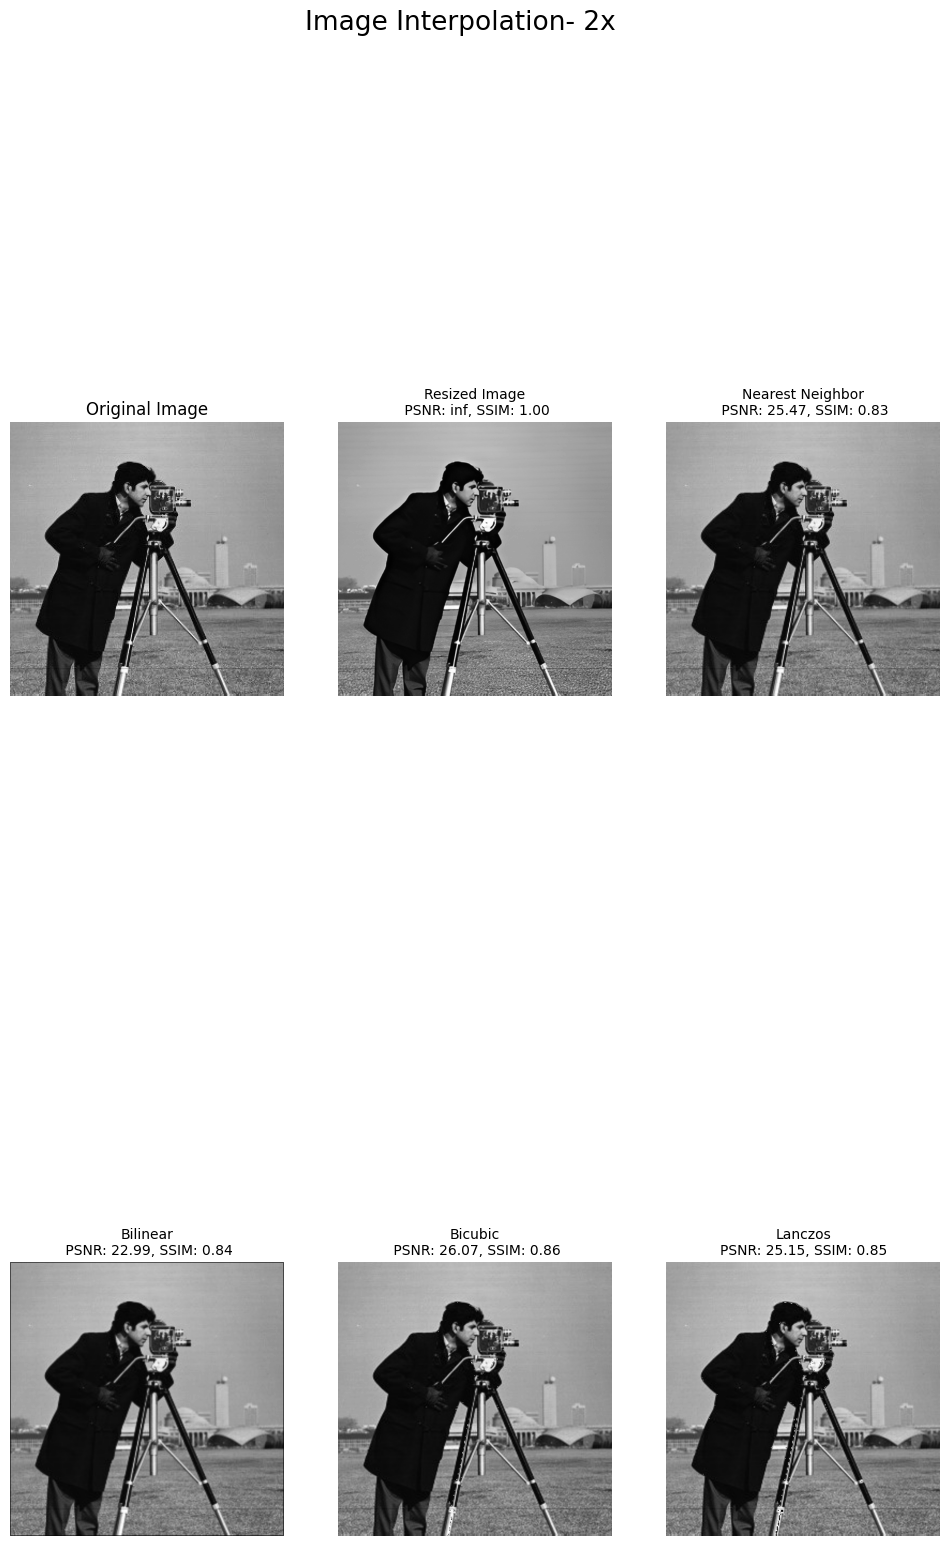

In [7]:
img_name = 'cameraman.jpg'
interpolation(img_name, 2)

Time taken for nearest neighbor: 0.7211291790008545 seconds
Time taken for bilinear: 11.964662075042725 seconds
Time taken for bicubic: 23.840336322784424 seconds
Time taken for bilanczos: 37.16832160949707 seconds


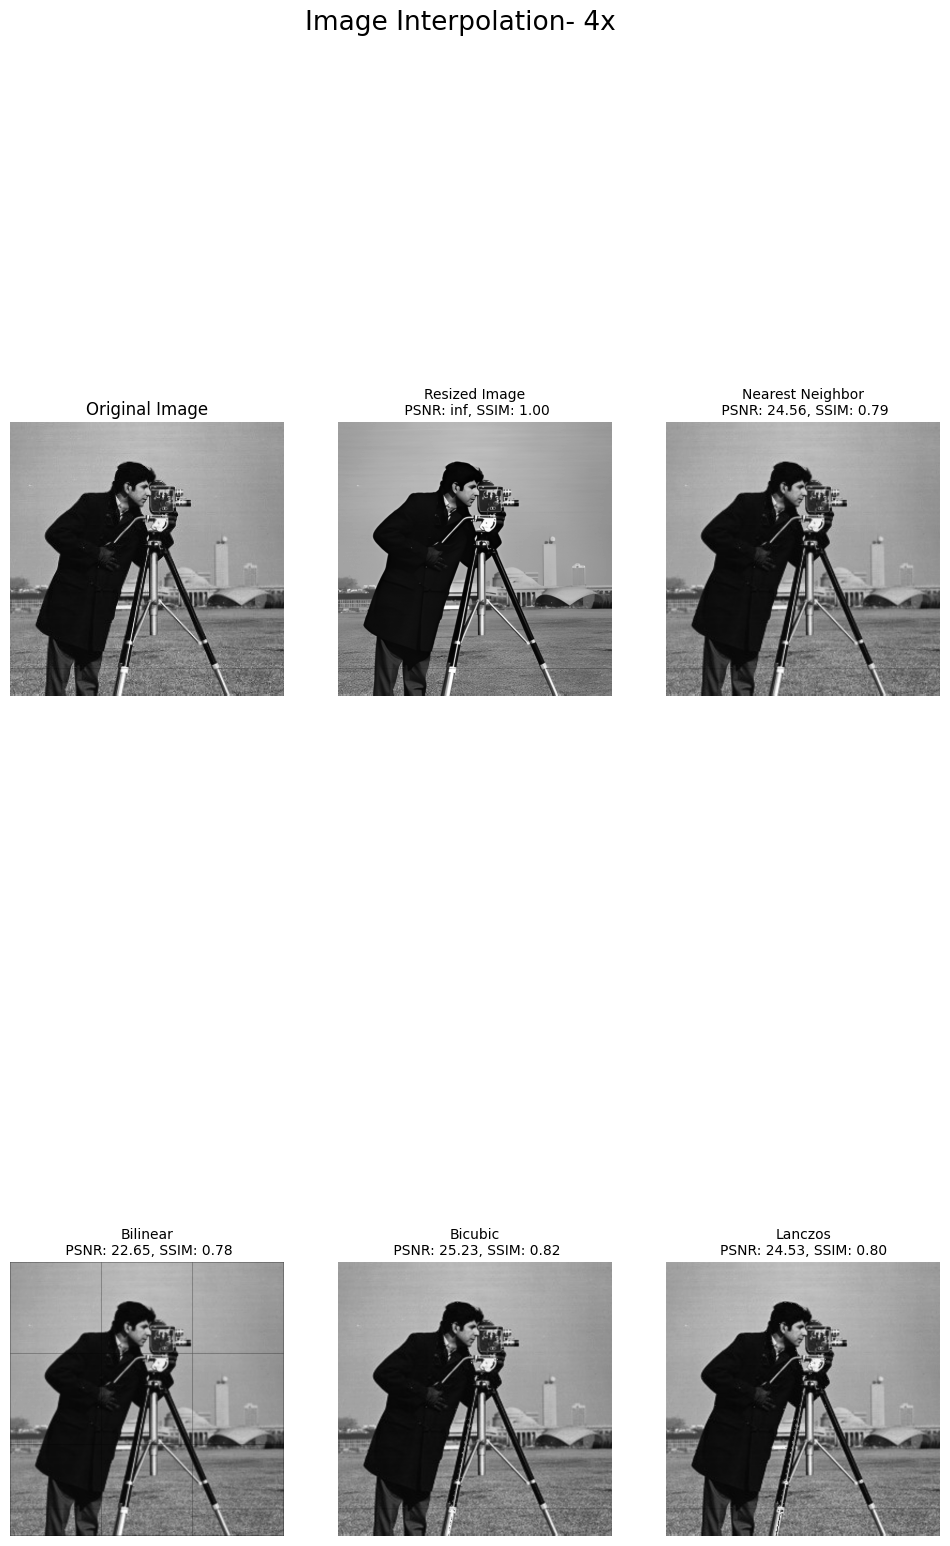

In [8]:
img_name = 'cameraman.jpg'
interpolation(img_name, 4)

Time taken for nearest neighbor: 1.0277493000030518 seconds
Time taken for bilinear: 22.003092765808105 seconds
Time taken for bicubic: 50.853360176086426 seconds
Time taken for bilanczos: 83.79747676849365 seconds


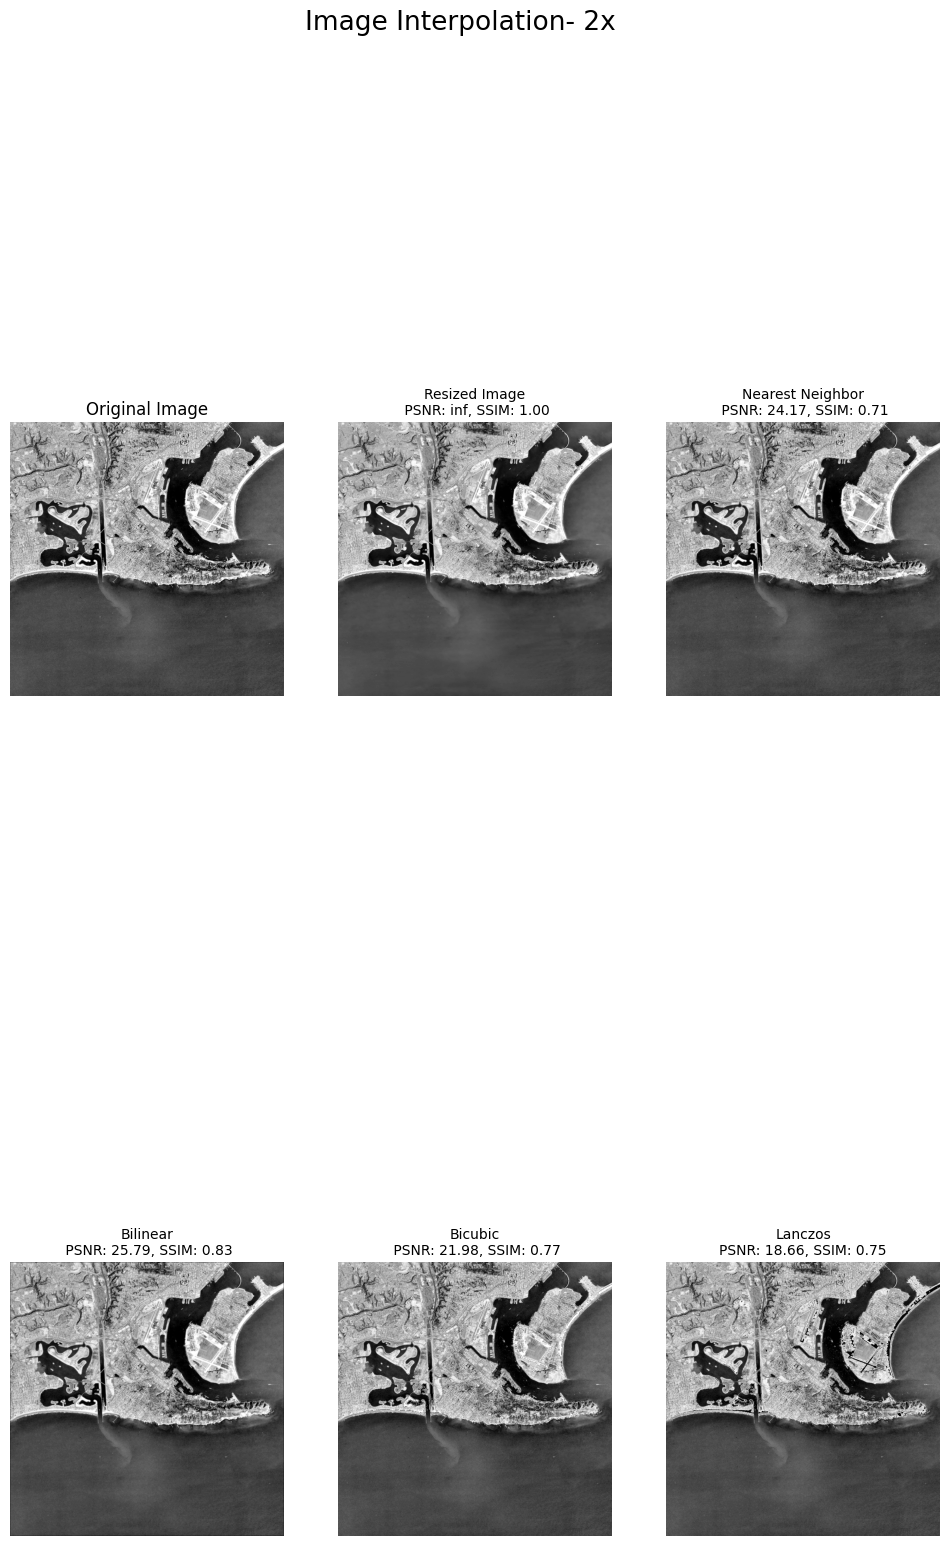

In [9]:
img_name = 'image.png'
interpolation(img_name, 2)

Time taken for nearest neighbor: 5.489595651626587 seconds
Time taken for bilinear: 85.77974057197571 seconds
Time taken for bicubic: 170.25030732154846 seconds
Time taken for bilanczos: 268.1499032974243 seconds


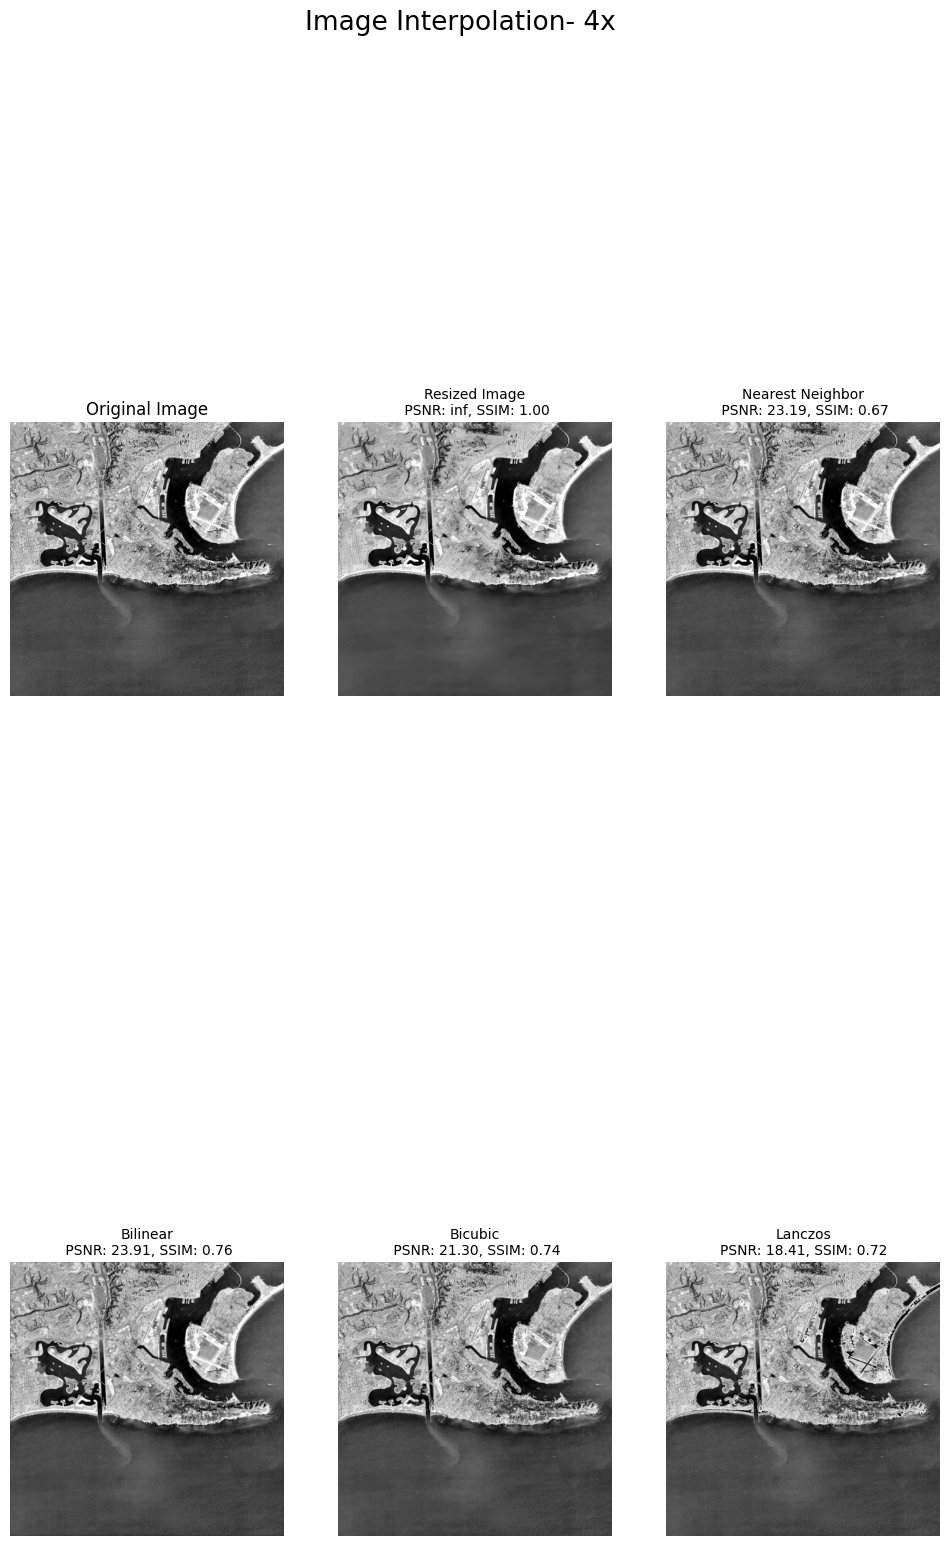

In [10]:
img_name = 'image.png'
interpolation(img_name, 4)